# Noob Data Project - Exploring AirBnB Data for Broke Couples
### Background Story and Premise:
Throughout my time studying in Amsterdam, I met and saw a lot of tourists. More than I could bargain for. This was because I lived near a very tourist-dense area where there were loads of international visitors and barely any Dutch people. (If you're asking how I managed to find an apartment to rent in this area, let's just say I got unbelievably lucky)

A category of tourists that I normally bumped into, besides families and drunken British boys in their mid 30's, were young couples. Usually hailing from other European countries, they wanted to temporarily escape their home, flying away to the most romantic honeymoon - and where else to spend this endeavour, if not for the one and only, premium adult playground that is Amsterdam?

There is a problem for these young couples, however. Amsterdam is a relatively expensive city. And when you're young, you're probably not going to be in the right spectrum when it comes to financial wellness - constantly asking about what this costs compared to that (well, unless you have rich parents or bought bitcoin back in 2012) - you're most likely going to be *broke*.

### Project Aim and Deliverable:

This brief project will attempt to conduct an exploratory data analysis for this target market. We will try and flesh out the best options for a couple short on cash looking to rent an Airbnb in the city of Amsterdam. 

The final deliverable however, will specifically come up with a tailored marketing advice pertaining to broke couples. Relevant stakeholders may be interested in finding out variables and trends which could prove useful in developing strategies for conversion. We may simplify the end goal by answering this question below: 

**What advice would I give the AirBnB marketing team, if their objective was to create advertisements for broke couples wanting to visit Amsterdam?**



In [1]:
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt
plt.style.use('seaborn')

In [8]:
listings_raw = pd.read_csv("Airbnb-data/listings_details.csv", low_memory= False)

Since the dataset has too much columns, let's narrow it down to the most important ones

In [9]:
colnames = ["id", "listing_url", "price","review_scores_rating", "number_of_reviews", "name","neighbourhood","beds",
            "bathrooms", "property_type","room_type", "accommodates", "minimum_nights", "availability_365",
            "latitude", "longitude"]

listingsv1 = listings_raw[colnames]

In [10]:
listingsv1.head() #Let's Peep the Dataset

,id,listing_url,price,review_scores_rating,number_of_reviews,name,neighbourhood,beds,bathrooms,property_type,room_type,accommodates,minimum_nights,availability_365,latitude,longitude
0,2818,https://www.airbnb.com/rooms/2818,$59.00,97.0,248,Quiet Garden View Room & Super Fast WiFi,Indische Buurt,2.0,1.5,Apartment,Private room,2,3,44,52.365755,4.941419
1,3209,https://www.airbnb.com/rooms/3209,$160.00,96.0,42,"Quiet apt near center, great view",Spaarndammer en Zeeheldenbuurt,2.0,1.0,Apartment,Entire home/apt,5,4,47,52.390225,4.873924
2,20168,https://www.airbnb.com/rooms/20168,$80.00,87.0,233,100%Centre-Studio 1 Private Floor/Bathroom,Grachtengordel,1.0,1.0,Townhouse,Entire home/apt,2,1,198,52.365087,4.893541
3,25428,https://www.airbnb.com/rooms/25428,$125.00,100.0,1,Lovely apt in City Centre (Jordaan),Grachtengordel,1.0,1.0,Apartment,Entire home/apt,3,14,141,52.373114,4.883668
4,27886,https://www.airbnb.com/rooms/27886,$150.00,99.0,171,"Romantic, stylish B&B houseboat in canal district",Westelijke Eilanden,1.0,1.0,Houseboat,Private room,2,2,199,52.386727,4.892078


----------------------------------------------------------------------------------------------------------------------

## PLAYGROUND! - Temporary Place to test Code

In [11]:
listings_raw['amenities'].loc[1]

'{Internet,Wifi,Kitchen,"Paid parking off premises","Pets live on this property",Cat(s),Heating,"Family/kid friendly",Washer,"Smoke detector","Fire extinguisher",Essentials,Shampoo,Hangers,"Hair dryer",Iron,"Laptop friendly workspace","Hot water","Coffee maker",Refrigerator,Dishwasher,"Dishes and silverware","Cooking basics",Oven,Stove,"Patio or balcony",Other}'

In [12]:
type(listings_raw['amenities'].loc[1])

str

----------------------------------------------------------------------------------------------------------------------

## Cleaning the Data / Setting Limits

In [13]:
#Clean Data with null values = beds, bathrooms 
listingsv1.dropna(subset = ['beds','bathrooms'], inplace=True)

<ipython-input-13-83fa0ede403b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  listingsv1.dropna(subset = ['beds','bathrooms'], inplace=True)


### Price Cleaning

In [14]:
# Convert price from object into int
listingsv1["price"] = listingsv1["price"].replace('[\$,]', '', regex=True).astype(float)

<ipython-input-14-248f660963d8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  listingsv1["price"] = listingsv1["price"].replace('[\$,]', '', regex=True).astype(float)


In [15]:
# Omit Data that has 0 for price value 
aboveZeroFilter = listingsv1['price'] > 1
listingsv1 = listingsv1[aboveZeroFilter]

In [16]:
#Let's convert the price from Dollars to Euros

Let's Check for Outliers in price by first visualizing and then the odd cases

<AxesSubplot:xlabel='price'>

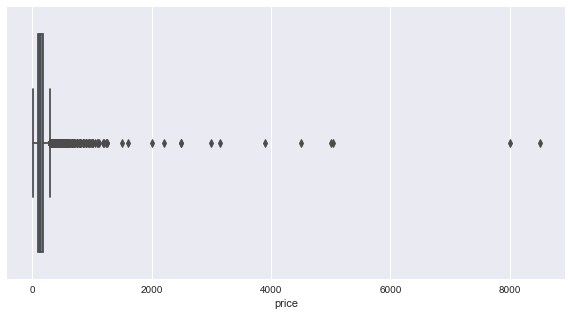

In [17]:
plt.figure(figsize = (10,5))
sns.boxplot(data=listingsv1, x='price')

As we can see, there are a bunch of outliers. It never ceases to amaze me how there is actually a couple of listings above 8000$. 

One may argue that since we are performing analysis only for a target that is 'broke', we can just omit prices that do not fall within a certain range - but hold on - just what do you mean by 'broke?' This is of course relative to every person, but to keep it as unambigious as possible, in this analysis I will work with what's below the 25th Percentile:

In [18]:
brokelimit = round(listingsv1['price'].quantile(q=0.25))
print(f'We will define the price limit as... {brokelimit}' + '$')

We will define the price limit as... 96$


96 dollars is not bad for a broke couple. If you divide that by two (assuming they're both paying equally) that is 48 dollars per/night. Personally, I think that's good enough for an limit on what constitutes as a 'broke' price max.

In [19]:
price_mask = listingsv1["price"] <= 96
listingsv1 = listingsv1[price_mask]
listingamount = listingsv1['price'].count()
print(f'In total, we have {listingamount} listings that fall within the price range')

In total, we have 5008 listings that fall within the price range


<AxesSubplot:xlabel='price'>

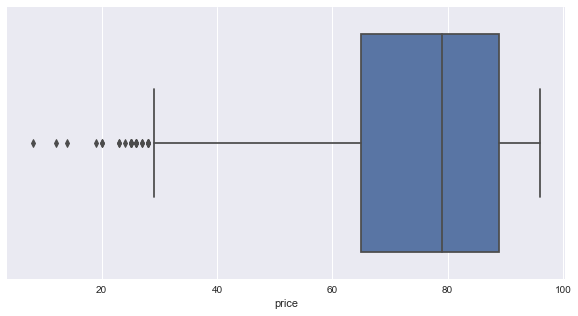

In [20]:
#Let's check the boxplot again - looks great to me!
plt.figure(figsize = (10,5))
sns.boxplot(data=listingsv1, x='price')

What's the price we can expect on average?

In [46]:
pricemean = round(listingsv1['price'].mean())
print(f'The average price, when setting the price limit of the data to the 25th Percentile is {pricemean}' + '$')

The average price, when setting the price limit of the data to the 25th Percentile is 76$


### Setting a filter which makes sure the listing is indeed for a couple
The 'accommodates' column indicates the maximum and minimum amount of guests a listing can hold. In our case, let's set it exactly to two.

In [22]:
coupleMask = listingsv1['accommodates'] == 2
listingsv1 = listingsv1[coupleMask]
listingcount = listingsv1['id'].count()
print(f'In total, we have {listingcount} listings that fall within the couple criteria')

In total, we have 3792 listings that fall within the couple criteria


All right, a total of 3792 listings. That's a good enough amount for us to start exploring and visualizing!

----------------------------------------------------------------------------------------------------------------------

## Exploratory Data Analysis

### A Closer Investigation of Neighbourhoods

Which Neighbourhood falls into our criteria the most? In other words, which neighbourhood has the most listings when it came to fitting into the criteria of a broke couple?

Text(0.5, 1.0, 'Top 10, Friendly-To-Broke-Couples Neighbourhoods')

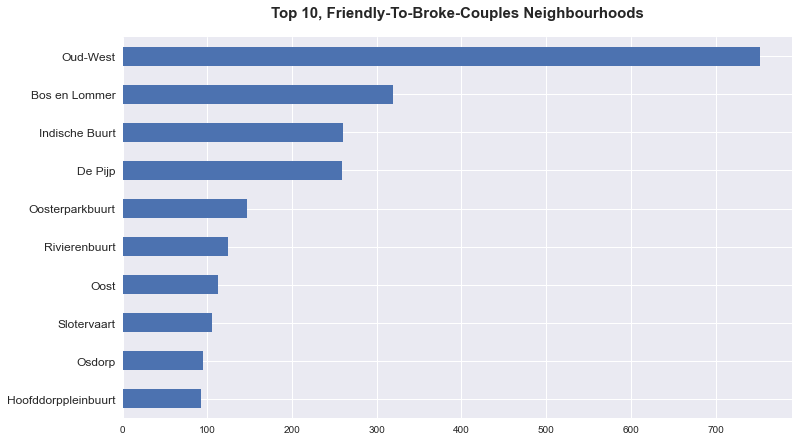

In [35]:
plt.figure(figsize=(12,7))
listingsv1['neighbourhood'].value_counts().head(10).plot(kind='barh').invert_yaxis()
plt.yticks(fontsize = 12, rotation = 0)
plt.title('Top 10, Friendly-To-Broke-Couples Neighbourhoods', fontsize= 15, fontweight = 'bold', pad = 20)

Looks like the neighbourhood of Oud-West takes the top spot by a big margin - This is no surprise because that area is primarily filled with residential apartments to begin with. But what about it's price? If you are a *truly broke* couple, you probably would prioritise price above everything else, correct?

Let us then ask, which areas have on average, the cheapest AirBnB listings when it comes to accommodating two people:

Text(0.5, 1.0, 'Top 10 Areas with Cheapest Listings (On Average)')

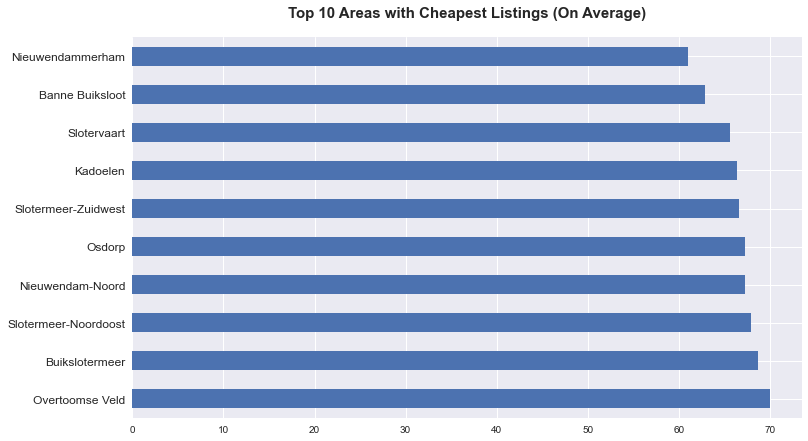

In [40]:
plt.figure(figsize=(12,7))
gbo = listingsv1.groupby('neighbourhood')
gbo['price'].mean().nsmallest(10).plot(kind='barh').invert_yaxis()
plt.yticks(fontsize = 12, rotation = 0)
plt.ylabel(None)
plt.title('Top 10 Areas with Cheapest Listings (On Average)', fontsize= 15, fontweight = 'bold', pad = 20)